# EEP 118 - Fall 2023

## Notebook 1

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid") # Set Seaborn style

In [14]:
## Setting Seed for Reproducibility
np.random.seed(10)  # for reproducibility

In [15]:
# Define number of simulations and sample size
num_simulations = 5000
sample_size = 200
# Define dataframe to store beta0 and beta1
simbetas = pd.DataFrame(columns=['beta0', 'sebeta0', 'beta1', 'sebeta1'])

## Running the Simulations 
We observe an i.i.d. sample $\left\{ Y_{i},X_{i}\right\} _{i=1}^{n}$
where where $Y_{i}$ is generated according to $Y_{i}=1-2X_{i}+\epsilon _{i}$ $\epsilon
 _{i}$ is an unobserved error term and is independent of $X_{i}$ and
 distributed uniformly.  Each $ X_{i}$ is drawn from normal
 distribution with mean zero and variance one. Change the sample_size
 variable above (from e.g. 5 to 200) and observe how your results
 change.

In [16]:
for sim in range(num_simulations):
    e = np.random.uniform(-3, 3, sample_size)
    x = np.random.normal(0, 1, sample_size)
    y = 1 - 2*x + e
    # Add constant to the x values for OLS regression
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
# Store beta coefficients and their standard errors
    simbetas.loc[sim] = [results.params[0], results.bse[0], results.params[1], results.bse[1]]

In [17]:
# Save dataframe to .csv file
simbetas.to_csv('simbetas.csv', index=False)


# Load the file with the estimated intervept and slope ceofficients (simbetas.csv)
simbetas1= pd.read_csv('simbetas.csv')
# compute summary statistics (mean,std,min,25,50,75 percentilles,max)    
stats = simbetas1.describe().applymap('{:,.2f}'.format)
# Print the summary statistics
print(stats)

          beta0   sebeta0     beta1   sebeta1
count  5,000.00  5,000.00  5,000.00  5,000.00
mean       1.00      0.12     -2.00      0.12
std        0.12      0.00      0.12      0.01
min        0.55      0.11     -2.44      0.10
25%        0.92      0.12     -2.08      0.12
50%        1.00      0.12     -2.00      0.12
75%        1.08      0.13     -1.91      0.13
max        1.50      0.14     -1.58      0.16


## Creating a histogram (and overlaying a normal density)

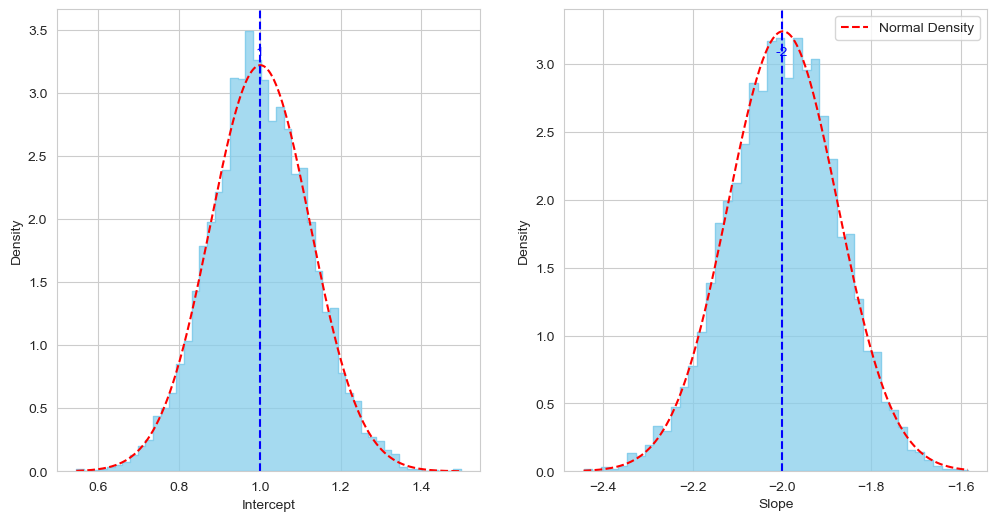

In [18]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot histograms of the intercept and slope with Seaborn
sns.histplot(simbetas1["beta0"], kde=False, ax=ax[0], color="skyblue", element="step", stat="density")
sns.histplot(simbetas1["beta1"], kde=False, ax=ax[1], color="skyblue", element="step", stat="density")
# Fit normal densities to the histograms
mu1, std1 = norm.fit(simbetas1["beta0"])
mu2, std2 = norm.fit(simbetas1["beta1"])
# Plot the normal densities on top of the histograms
x1 = np.linspace(simbetas1["beta0"].min(), simbetas1["beta0"].max(), 1000)
y1 = norm.pdf(x1, mu1, std1)
x2 = np.linspace(simbetas1["beta1"].min(), simbetas1["beta1"].max(), 1000)
y2 = norm.pdf(x2, mu2, std2)
ax[0].plot(x1, y1, linestyle="--", color="red", label="Normal Density")
ax[1].plot(x2, y2, linestyle="--", color="red", label="Normal Density")
# Add blue dashed lines at x=1 for the intercept and x=-2 for the slope
ax[0].axvline(x=1, color='blue', linestyle='--')
ax[1].axvline(x=-2, color='blue', linestyle='--')
# Annotate the x=1 and x=-2 on the plots
ax[0].text(1, ax[0].get_ylim()[1]*0.9, '1', color='blue', ha='center')
ax[1].text(-2, ax[1].get_ylim()[1]*0.9, '-2', color='blue', ha='center')
# Add labels and legend to the plots
ax[0].set_xlabel("Intercept")
ax[1].set_xlabel("Slope")
plt.legend()
plt.show()


## Constructing the Q-Q Plots
### The comparison between the histogram and the normal density suggest that the histogram is less well approximated by the normaldistribution at the tails of the distribution. We examine this in more detail by comparing the quantiles of the two distribution.

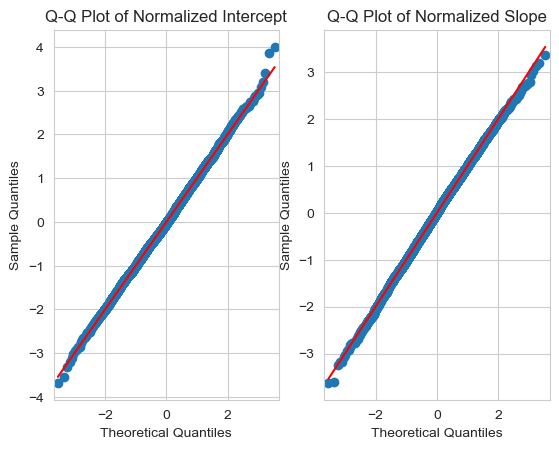

In [19]:
normalized_beta0 = (simbetas1["beta0"] - simbetas1["beta0"].mean()) / simbetas1["beta0"].std()
normalized_beta1 = (simbetas1["beta1"] - simbetas1["beta1"].mean()) / simbetas1["beta1"].std()
# Create a figure with 2 subplots
fig, ax = plt.subplots(nrows=1, ncols=2)
# Generate Q-Q plots for the normalized intercept and slope
qqplot(normalized_beta0, line="s", ax=ax[0])
qqplot(normalized_beta1, line="s", ax=ax[1])
# Add titles
ax[0].set_title('Q-Q Plot of Normalized Intercept')
ax[1].set_title('Q-Q Plot of Normalized Slope')
plt.show()

### Compute the teststat variable

In [20]:
simbetas1['teststat'] = (simbetas1['beta1'] + 2) / simbetas1['sebeta1']
# Compute the cval, which is the 97.5th percentile of a standard normal distribution
cval = norm.ppf(0.975)
# Generate the reject variable, equal to 1 if the absolute value of teststat > cval, and 0 otherwise
simbetas1['reject'] = (simbetas1['teststat'].abs() > cval).astype(int)
# Compute summary statistics for the reject variable
reject_stats = simbetas1['reject'].describe().apply('{:,.2f}'.format)
print(reject_stats)

count    5,000.00
mean         0.05
std          0.22
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: reject, dtype: object


### Next, test $H_0:\beta_1=0$ vs $H_1:\beta_1\neq 0$ Since $\beta_1=-2$ our test should reject the null with high probability. Examine the mean of the reject_stats2 variable 

In [21]:

# Compute the teststat2 variable
simbetas1['teststat2'] = (simbetas1['beta1']) / simbetas1['sebeta1']
# Generate the reject variable, equal to 1 if the absolute value of teststat > cval, and 0 otherwise
simbetas1['reject2'] = (simbetas1['teststat2'].abs() > cval).astype(int)
# Compute summary statistics for the reject variable
reject_stats2 = simbetas1['reject2'].describe().apply('{:,.2f}'.format)
print(reject_stats2)

count    5,000.00
mean         1.00
std          0.00
min          1.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: reject2, dtype: object
